# Create unified catalog
Update of the 31/07/2023 : author [tomsail](https://github.com/tomsail) (Thomas Saillour)

In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import shapely

In [2]:
%matplotlib widget

## COOPS

In [3]:
from searvey.coops import coops_stations

coops = coops_stations()
coops

,nws_id,name,state,status,removed,geometry
nos_id,,,,,,
1600012,46125,QREB buoy,,active,<NA>,POINT (122.60028 37.75008)
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,POINT (-177.36000 28.21167)
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,POINT (144.65636 13.44339)
1631428,PGBP7,"Pago Bay, Guam",,active,<NA>,POINT (144.79700 13.42830)
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,POINT (-170.68944 -14.27667)
...,...,...,...,...,...,...
8770570,SBPT2,Sabine Pass North,TX,discontinued,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0...",POINT (-93.87010 29.72840)
8775870,MQTT2,"Bob Hall Pier, Corpus Christi",TX,discontinued,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0...",POINT (-97.21670 27.58000)
8740166,GBRM6,"Grand Bay NERR, Mississippi Sound",MS,discontinued,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1...",POINT (-88.40289 30.41319)


In [4]:
### get lat/lon
coops['lon'] = coops['geometry'].x
coops['lat'] = coops['geometry'].y


In [5]:
coops = coops.drop('geometry',axis=1)
coops

,nws_id,name,state,status,removed,lon,lat
nos_id,,,,,,,
1600012,46125,QREB buoy,,active,<NA>,122.600281,37.750080
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,-177.360001,28.211670
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,144.656357,13.443390
1631428,PGBP7,"Pago Bay, Guam",,active,<NA>,144.796997,13.428300
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,-170.689438,-14.276670
...,...,...,...,...,...,...,...
8770570,SBPT2,Sabine Pass North,TX,discontinued,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0...",-93.870102,29.728399
8775870,MQTT2,"Bob Hall Pier, Corpus Christi",TX,discontinued,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0...",-97.216698,27.580000
8740166,GBRM6,"Grand Bay NERR, Mississippi Sound",MS,discontinued,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1...",-88.402893,30.413191


## IOC

In [6]:
from searvey import ioc
ioc_stations = ioc.get_ioc_stations_api()
ioc_stations['lon'] = ioc_stations['geometry'].x
ioc_stations['lat'] = ioc_stations['geometry'].y
ioc_stations = ioc_stations.drop('geometry',axis=1)
# dropping all duplicates 
ioc_stations = ioc_stations.drop_duplicates(subset=['ioc_code'])
ioc_stations


,ioc_code,Location,country,type,DCP_ID,WMO,XMtInt,lat,lon,Har,...,samples,units,i,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,10.0,F,NaN,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.717,2.395728,SWJP40,Japan
1,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,1.0,M,NaN,5.0,1.0,2023-09-08 08:30:00.000,2023-09-08 08:48:05.000,3.400000,SF,UK
2,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,10.0,F,NaN,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.840,2.749296,SWJP40,Japan
3,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,1.0,min,NaN,4.0,-1.0,2023-09-08 08:43:00.000,2023-09-08 08:45:04.497,6.173000,SZXX01,El Salvador
9,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,None,NaN,NaN,NaN,2017-07-07 01:00:00.000,2017-07-07 01:06:04.923,8.257000,SEPA40,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,zhap,Zhapo,CHN,SL,09731,SZCI01,1.0,21.580000,111.820000,NaN,...,5.0,M,NaN,0.0,1.0,2023-09-08 08:30:00.000,2023-09-08 08:46:02.200,1.790000,SZCI01,China
2124,zihu,"Zihuatanejo, Gro",MEX,SF,None,None,15.0,17.636667,-101.558333,NaN,...,30.0,M,NaN,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:48:42.000,3.193000,SF,Mexico
2125,zihu2,Zihuatanejo2,MEX,SL,0102D23E,SOMX10,10.0,17.636183,-101.558183,NaN,...,10.0,M,0.0,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:44:03.247,3.193000,SOMX10,Mexico
2127,zygi,Zygi,CYP,SF,None,None,1.0,34.727083,33.338375,0.0,...,NaN,None,NaN,NaN,NaN,2015-06-19 03:18:16.000,2015-06-19 10:01:53.000,1.914000,SF,Cyprus


## EMODNET

In [7]:
emodnet = pd.read_csv('emodnet.csv')
emodnet = emodnet.drop_duplicates(['EP_PLATFORM_CODE'])
emodnet[~emodnet.EP_PLATFORM_ID.isna()]

,Unnamed: 0,EP_PLATFORM_ID,EP_PLATFORM_TYPE,EP_PLATFORM_CODE,EP_PLATFORM_LINK,TIME_QC (1),latitude (degrees_north),longitude (degrees_east),SLEV_QC (1),SLEV_DM,...,area,author,source,contributor_name,contributor_url,data_assembly_center,institution_edmo_code,institution_references,institution,wmo_platform_code
0,0,8397,TG,AjaccioTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,41.92270,8.76290,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
4,5864277,8425,TG,ArcachonEyracTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,44.66500,-1.16350,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
8,11550389,371096,TG,AudierneTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,48.02155,-4.53758,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
12,13443083,638729,TG,BaliseARouenTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,49.43183,0.11067,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
13,13443197,8447,TG,BayonneBoucauTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,43.52730,-1.51540,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,262348559,8901,TG,SolenzaraTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,41.85686,9.40383,1,D,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
275,266904056,368642,TG,ThioTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,-21.61381,166.24153,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
279,270225196,8985,TG,ToulonTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,43.12280,5.91460,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
283,271731957,371433,TG,TubuaiTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,-23.34177,-149.47554,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN


## CMEMS

In [8]:
cmems = pd.read_csv('cmems.csv')
cmems = cmems.drop(cmems.columns[0],axis=1)
cmems = cmems.drop_duplicates()

In [9]:
cmems.columns

Index(['PLATFORM_NAME', 'PLATFORM_CODE', 'INSTITUTION',
       'INSTITUTION_EDMO_CODE', 'latitude (degrees_north)',
       'longitude (degrees_east)'],
      dtype='object')

## GESLA
### Initialize a GeslaDataset object
First clone the following repository: `https://github.com/philiprt/GeslaDataset`.
Also download the whole GESLA3 dataset at this url: `https://gesla787883612.wordpress.com/downloads/`. 

Then place the `gesla.py` file in your working directory (or elsewhere on your path), and import the `GeslaDataset` class. Selecting and loading data files requires paths to the metadata .csv file and the directory containing the data files. Initialize a `GeslaDataset` object with these paths as follows.

In [10]:
meta_file = "./GESLA3_ALL.csv"
data_path = "/home/tomsail/Documents/scripts/Python/GeslaDataset/GESLA3.0_ALL/"
from gesla import GeslaDataset

g3 = GeslaDataset(meta_file=meta_file, data_path=data_path)

For possible future sources we can use gesla sources

In [11]:
g3.meta.contributor_website.unique()
g3.meta

,filename,site_name,site_code,country,contributor_abbreviated,contributor_full,contributor_website,contributor_contact,orginator,originator_website,...,start_date_time,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality
0,aasiaat-aas-grl-gloss,Aasiaat,AAS,GRL,GLOSS,Global Sea Level Observing System,https://www.gloss-sealevel.org,I.D.Haigh@soton.ac.uk,Global Sea Level Observing System,https://www.gloss-sealevel.org,...,1997-06-26 15:53:00,1999-06-28 11:18:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
1,maniitsoq-man-grl-gloss,Maniitsoq,MAN,GRL,GLOSS,Global Sea Level Observing System,https://www.gloss-sealevel.org,I.D.Haigh@soton.ac.uk,Global Sea Level Observing System,https://www.gloss-sealevel.org,...,1997-06-30 21:02:00,1999-06-20 23:53:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
2,brest-822a-fra-uhslc,Brest,822A,FRA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,Systeme d'Observation du Niveau des Eaux Litto...,Unspecified,...,1846-01-04 00:00:00,2018-12-31 23:00:00,165,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
3,stockholm-826a-swe-uhslc,Stockholm,826A,SWE,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,Swedish Meteorological and Hydrographical Ins...,Unspecified,...,1889-01-01 00:00:00,2014-12-31 23:00:00,125,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
4,san_francisco_ca-551a-usa-uhslc,San_Francisco_CA,551A,USA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,National Ocean Service (NOS) National Oceani...,Unspecified,...,1897-08-01 08:00:00,2018-12-31 23:00:00,122,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5114,sian_ka_an-418-mex-unam,Sian_Ka_An,418,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2016-01-01 00:00:00,2018-12-31 23:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
5115,sisal-416-mex-unam,Sisal,416,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2011-01-01 00:00:00,2013-12-30 11:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
5116,zihuatanejo-509-mex-unam,Zihuatanejo,509,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2011-01-01 00:00:00,2013-12-30 11:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
5117,celestun-412-mex-unam,Celestun,412,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2010-01-01 00:00:00,2011-12-31 23:00:00,2,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues


### normalize name, lon, lat

In [12]:
coops = coops.rename(columns={'name':'Station_Name','lon':'longitude','lat':'latitude'})

In [13]:
ioc_stations = ioc_stations.rename(columns={'Location':'Station_Name','lon':'longitude','lat':'latitude'})

In [14]:
cmems = cmems.rename(columns={'PLATFORM_NAME':'Station_Name','longitude (degrees_east)':'longitude','latitude (degrees_north)':'latitude'})
cmems

,Station_Name,PLATFORM_CODE,INSTITUTION,INSTITUTION_EDMO_CODE,latitude,longitude
0,Aarhus,Aarhus,DMI,469,56.1500,10.21670
1,Althagen,Althagen,BSH,1850,54.3769,12.41940
2,Ark\u00f6 mobi,Arko,SMHI,545,58.4843,16.96070
3,Assens,Assens,DMI,469,55.2667,9.88330
4,Bagenkop,Bagenkop,DMI,469,54.7528,10.67780
...,...,...,...,...,...,...
792,Iles Du Salut,IlesDuSalutTG,SHOM Service Hydrographique et Oceanographiqu...,540,5.2500,-52.62000
849,NaN,IDSL-ZygiMarina,Joint Research Centre(JRC);Cyprus Oceanography...,2688 711,34.7263,33.34020
878,NaN,IDSL-Corinth,Joint Research Centre(JRC);National Observator...,2688 1202,37.9425,22.93360
879,NaN,IDSL-Ciutadella,Joint Research Centre(JRC);Instituto Geogr\u00...,2688,39.9876,3.82815


In [15]:
emodnet = emodnet.rename(columns={'EP_PLATFORM_CODE':'Station_Name','longitude (degrees_east)':'longitude','latitude (degrees_north)':'latitude'})
emodnet

,Unnamed: 0,EP_PLATFORM_ID,EP_PLATFORM_TYPE,Station_Name,EP_PLATFORM_LINK,TIME_QC (1),latitude,longitude,SLEV_QC (1),SLEV_DM,...,area,author,source,contributor_name,contributor_url,data_assembly_center,institution_edmo_code,institution_references,institution,wmo_platform_code
0,0,8397,TG,AjaccioTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,41.92270,8.76290,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
4,5864277,8425,TG,ArcachonEyracTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,44.66500,-1.16350,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
8,11550389,371096,TG,AudierneTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,48.02155,-4.53758,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
12,13443083,638729,TG,BaliseARouenTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,49.43183,0.11067,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
13,13443197,8447,TG,BayonneBoucauTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,43.52730,-1.51540,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,262348559,8901,TG,SolenzaraTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,41.85686,9.40383,1,D,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
275,266904056,368642,TG,ThioTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,-21.61381,166.24153,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
279,270225196,8985,TG,ToulonTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,43.12280,5.91460,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
283,271731957,371433,TG,TubuaiTG,http://www.emodnet-physics.eu/Map/spi.aspx?id=...,1,-23.34177,-149.47554,1,\u0000,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540,NaN,SHOM Service Hydrographique et Oceanographique...,NaN


In [16]:
gesla3 = g3.meta.rename(columns={'site_name':'Station_Name','longitude':'longitude','latitude':'latitude'})

## Plot

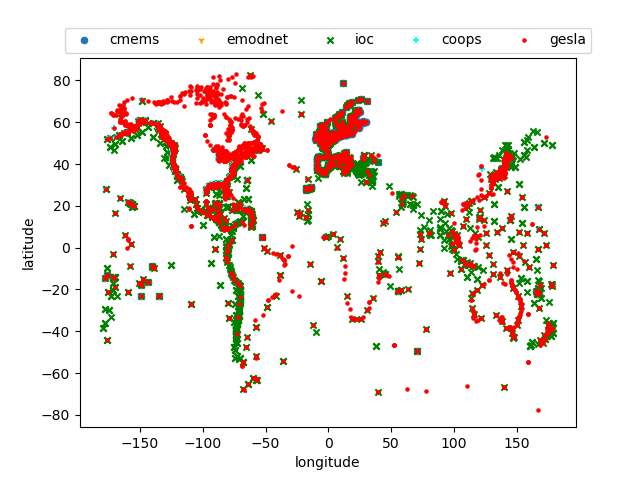

In [17]:
cmems.plot.scatter(x = 'longitude', y = 'latitude', marker='o', label='cmems')
a = plt.gca()
emodnet.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='orange', marker='1', label='emodnet')
ioc_stations.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='green', marker='x', label='ioc')
coops.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='cyan', marker='+', label='coops')
gesla3.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='red', marker='.',label='gesla')
plt.legend(loc='upper center',bbox_to_anchor=(.5, 1.1), ncol=5)

## Merge COOPS & ioc_stations

#### check duplicates

In [18]:
ioc_ = ioc_stations.loc[ioc_stations.country=='USA']
ioc_

,ioc_code,Station_Name,country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,samples,units,i,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname
11,acnj,Atlantic_City_NJ,USA,SW,3367B730,SXXX03,6.0,39.3550,-74.4183,0.0,...,6.0,M,0.0,0.0,1.0,2023-09-08 08:45:00.000,2023-09-08 08:48:01.000,1.108,SXXX03,USA
12,acnj2,Atlantic_City_NJ,USA,SL,3367B730,SXXX03,6.0,39.3550,-74.4183,0.0,...,6.0,M,0.0,0.0,-1.0,2023-09-08 08:38:00.000,2023-09-08 08:45:04.810,-7.703,SXXX03,USA
15,adak,Adak_AK,USA,SW,3360F60E,SXXX03,6.0,51.8630,-176.6320,1.0,...,6.0,M,0.0,0.0,-1.0,2023-09-08 08:40:00.000,2023-09-08 08:46:02.000,0.985,SXXX03,USA
16,adak2,Adak_AK,USA,SL,3360F60E,SXXX03,6.0,51.8630,-176.6320,1.0,...,6.0,M,0.0,0.0,-1.0,2023-09-08 08:42:00.000,2023-09-08 08:48:02.903,-2.264,SXXX03,USA
28,alak,Alitak_US,USA,SW,3363341E,SXXX03,6.0,56.8975,-154.2481,1.0,...,6.0,M,0.0,4.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:44:02.000,1.702,SXXX03,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,wpwa2,"Westport, WA",USA,SL,33632768,SXXX03,6.0,46.9083,-124.1100,1.0,...,NaN,None,NaN,NaN,NaN,2015-09-10 15:25:00.000,2015-09-10 15:32:01.993,-5.738,SXXX03,USA
2093,wsdc,Washington_DC,USA,NA,335861BA,SXXX50,6.0,38.8700,-77.0200,0.0,...,NaN,None,NaN,NaN,NaN,None,None,NaN,SXXX50,USA
2103,yabu,"Yabucoa Harbor, PR",USA,SL,3366B5CA,SXXX03,6.0,18.0551,-65.8330,0.0,...,6.0,M,0.0,0.0,-1.0,2023-09-08 08:38:00.000,2023-09-08 08:44:02.153,-6.409,SXXX03,USA
2104,yaku,Yakutat_AK,USA,SW,336B0522,SXXX03,6.0,59.5480,-139.7350,1.0,...,6.0,M,0.0,2.0,-1.0,2023-09-08 08:37:00.000,2023-09-08 08:44:40.000,0.853,SXXX03,USA


In [19]:
ioc_.country.unique()

array(['USA'], dtype=object)

In [20]:
m1 = pd.merge(ioc_,coops, on=['Station_Name']).Station_Name

In [21]:
m1

0      Lake Charles
1          Monterey
2          Monterey
3    Port Alexander
4    Pago Bay, Guam
Name: Station_Name, dtype: object

In [22]:
i1 = ioc_.loc[ioc_.Station_Name.isin(m1)]
i1 = i1.drop_duplicates(['Station_Name']).reset_index(drop=True)
i1 = i1.sort_values('Station_Name').reset_index(drop=True)
i1

,ioc_code,Station_Name,country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,samples,units,i,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname
0,lcla,Lake Charles,USA,SL,33435016,SXXX03,6.0,30.2016,-93.2806,NaN,...,NaN,None,NaN,NaN,NaN,None,None,NaN,SXXX03,USA
1,mont,Monterey,USA,SW,33630184,SXXX03,6.0,36.6050,-121.8867,0.0,...,6.0,M,NaN,0.0,1.0,2023-09-08 08:37:00.000,2023-09-08 08:44:29.000,0.173,SXXX03,USA
2,pagb,"Pago Bay, Guam",USA,SW,None,None,6.0,13.4283,144.7970,0.0,...,1.0,M,0.0,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:44:32.000,0.560,SW,USA
3,paak2,Port Alexander,USA,SW,None,None,6.0,56.2467,-134.6467,NaN,...,6.0,M,NaN,0.0,-1.0,2023-09-08 08:41:00.000,2023-09-08 08:48:31.000,0.819,SW,USA


In [23]:
g1 = coops.loc[coops.Station_Name.isin(m1)]
g1 = g1.sort_values('Station_Name').reset_index(drop=True)
g1

,nws_id,Station_Name,state,status,removed,longitude,latitude
0,LCLL1,Lake Charles,LA,active,"2023-03-02 00:00:00,2023-01-13 12:00:00,2022-1...",-93.221672,30.223610
1,MEYC1,Monterey,CA,active,"2023-02-27 00:00:00,2023-02-24 00:00:00,2020-0...",-121.891388,36.608891
2,PGBP7,"Pago Bay, Guam",,active,<NA>,144.796997,13.428300
3,PLXA2,Port Alexander,AK,active,"2022-05-20 22:00:00,2022-05-20 00:00:00,2018-0...",-134.647003,56.246700


### Lat/Lon differences

In [24]:
np.abs(i1.longitude - g1.longitude).max()

0.058927941894538094

In [25]:
np.abs(i1.latitude - g1.latitude).max()

0.022009924316407137

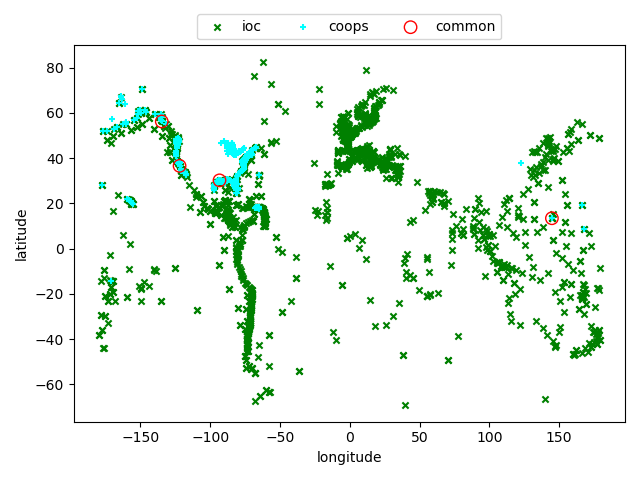

In [26]:
ioc_stations.plot.scatter(x = 'longitude', y = 'latitude', color='green', marker='x', label='ioc')
a = plt.gca()
coops.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='cyan', marker='+', label='coops')

plt.scatter(x=i1.longitude, y=i1.latitude, s=80, facecolors='none', edgecolors='r', label='common')
plt.legend(loc='upper center',bbox_to_anchor=(.5, 1.1), ncol=10)
plt.tight_layout()

In [27]:
unique = coops[~coops.Station_Name.isin(m1)]
unique

,nws_id,Station_Name,state,status,removed,longitude,latitude
nos_id,,,,,,,
1600012,46125,QREB buoy,,active,<NA>,122.600281,37.750080
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,-177.360001,28.211670
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,144.656357,13.443390
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,-170.689438,-14.276670
1820000,KWJP8,"Kwajalein, Marshall Islands",,active,<NA>,167.736115,8.731670
...,...,...,...,...,...,...,...
8770570,SBPT2,Sabine Pass North,TX,discontinued,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0...",-93.870102,29.728399
8775870,MQTT2,"Bob Hall Pier, Corpus Christi",TX,discontinued,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0...",-97.216698,27.580000
8740166,GBRM6,"Grand Bay NERR, Mississippi Sound",MS,discontinued,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1...",-88.402893,30.413191


#### normalize country column

In [28]:
ioc_stations = ioc_stations.rename(columns={'country':'Country'})

In [29]:
coops['Country'] = 'United States'

In [30]:
catalog = pd.concat([ioc_stations, coops], ignore_index=True)
catalog.reset_index(inplace=True,drop=True)
catalog

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname,nws_id,state,removed
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.717,2.395728,SWJP40,Japan,<NA>,<NA>,<NA>
1,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,5.0,1.0,2023-09-08 08:30:00.000,2023-09-08 08:48:05.000,3.400000,SF,UK,<NA>,<NA>,<NA>
2,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.840,2.749296,SWJP40,Japan,<NA>,<NA>,<NA>
3,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,4.0,-1.0,2023-09-08 08:43:00.000,2023-09-08 08:45:04.497,6.173000,SZXX01,El Salvador,<NA>,<NA>,<NA>
4,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,NaN,2017-07-07 01:00:00.000,2017-07-07 01:06:04.923,8.257000,SEPA40,Mexico,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,Sabine Pass North,United States,NaN,NaN,NaN,NaN,29.728399,-93.870102,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBPT2,TX,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0..."
1977,NaN,"Bob Hall Pier, Corpus Christi",United States,NaN,NaN,NaN,NaN,27.580000,-97.216698,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQTT2,TX,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0..."
1978,NaN,"Grand Bay NERR, Mississippi Sound",United States,NaN,NaN,NaN,NaN,30.413191,-88.402893,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBRM6,MS,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1..."
1979,NaN,Wells,United States,NaN,NaN,NaN,NaN,43.320000,-70.563301,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELM1,ME,"2022-08-03 00:00:00,2016-08-09 12:00:00,2016-0..."


### test it

In [31]:
minlat = g1.latitude.min(),
maxlat = g1.latitude.max(),
minlon = g1.longitude.min(),
maxlon = g1.longitude.max(),

In [32]:
w = catalog.loc[(catalog['longitude'] > minlon) & (catalog['longitude'] < maxlon) & (catalog['latitude'] > minlat) & (catalog['latitude'] < maxlat)]

In [33]:
w.reset_index(inplace=True, drop=True)

In [34]:
w

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname,nws_id,state,removed
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.717,2.395728,SWJP40,Japan,<NA>,<NA>,<NA>
1,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.840,2.749296,SWJP40,Japan,<NA>,<NA>,<NA>
2,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,4.0,-1.0,2023-09-08 08:43:00.000,2023-09-08 08:45:04.497,6.173000,SZXX01,El Salvador,<NA>,<NA>,<NA>
3,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,NaN,2017-07-07 01:00:00.000,2017-07-07 01:06:04.923,8.257000,SEPA40,Mexico,<NA>,<NA>,<NA>
4,acap2,Acapulco API,MEX,SL,0100D7CA,SOMX10,10.0,16.837933,-99.903000,NaN,...,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:44:06.920,4.463000,SOMX10,Mexico,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,NaN,Sabine Pass North,United States,NaN,NaN,NaN,NaN,29.728399,-93.870102,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBPT2,TX,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0..."
1203,NaN,"Bob Hall Pier, Corpus Christi",United States,NaN,NaN,NaN,NaN,27.580000,-97.216698,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQTT2,TX,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0..."
1204,NaN,"Grand Bay NERR, Mississippi Sound",United States,NaN,NaN,NaN,NaN,30.413191,-88.402893,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBRM6,MS,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1..."
1205,NaN,Wells,United States,NaN,NaN,NaN,NaN,43.320000,-70.563301,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELM1,ME,"2022-08-03 00:00:00,2016-08-09 12:00:00,2016-0..."


In [35]:
w.loc[~w.ioc_code.isna()] # these can be downloaded from IOC

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname,nws_id,state,removed
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.717,2.395728,SWJP40,Japan,<NA>,<NA>,<NA>
1,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.840,2.749296,SWJP40,Japan,<NA>,<NA>,<NA>
2,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,4.0,-1.0,2023-09-08 08:43:00.000,2023-09-08 08:45:04.497,6.173000,SZXX01,El Salvador,<NA>,<NA>,<NA>
3,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,NaN,2017-07-07 01:00:00.000,2017-07-07 01:06:04.923,8.257000,SEPA40,Mexico,<NA>,<NA>,<NA>
4,acap2,Acapulco API,MEX,SL,0100D7CA,SOMX10,10.0,16.837933,-99.903000,NaN,...,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:44:06.920,4.463000,SOMX10,Mexico,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,zhap,Zhapo,CHN,SL,09731,SZCI01,1.0,21.580000,111.820000,NaN,...,0.0,1.0,2023-09-08 08:30:00.000,2023-09-08 08:46:02.200,1.790000,SZCI01,China,<NA>,<NA>,<NA>
797,zihu,"Zihuatanejo, Gro",MEX,SF,None,None,15.0,17.636667,-101.558333,NaN,...,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:48:42.000,3.193000,SF,Mexico,<NA>,<NA>,<NA>
798,zihu2,Zihuatanejo2,MEX,SL,0102D23E,SOMX10,10.0,17.636183,-101.558183,NaN,...,0.0,1.0,2023-09-08 08:36:00.000,2023-09-08 08:44:03.247,3.193000,SOMX10,Mexico,<NA>,<NA>,<NA>
799,zygi,Zygi,CYP,SF,None,None,1.0,34.727083,33.338375,0.0,...,NaN,NaN,2015-06-19 03:18:16.000,2015-06-19 10:01:53.000,1.914000,SF,Cyprus,<NA>,<NA>,<NA>


In [36]:
w.loc[~w.nws_id.isna()] # these can be downloaded from COOPS

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname,nws_id,state,removed
801,NaN,QREB buoy,United States,NaN,NaN,NaN,NaN,37.750080,122.600281,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46125,,<NA>
802,NaN,"Apra Harbor, Guam",United States,NaN,NaN,NaN,NaN,13.443390,144.656357,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APRP7,,<NA>
803,NaN,Bermuda Biological Station,United States,NaN,NaN,NaN,NaN,32.369999,-64.695000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRCB6,,<NA>
804,NaN,"Bermuda, St. Georges Island",United States,NaN,NaN,NaN,NaN,32.373310,-64.703308,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BEPB6,,<NA>
805,NaN,East Bay Causeway,United States,NaN,NaN,NaN,NaN,27.928890,-82.425751,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TSHF1,FL,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,NaN,Sabine Pass North,United States,NaN,NaN,NaN,NaN,29.728399,-93.870102,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBPT2,TX,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0..."
1203,NaN,"Bob Hall Pier, Corpus Christi",United States,NaN,NaN,NaN,NaN,27.580000,-97.216698,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQTT2,TX,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0..."
1204,NaN,"Grand Bay NERR, Mississippi Sound",United States,NaN,NaN,NaN,NaN,30.413191,-88.402893,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBRM6,MS,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1..."
1205,NaN,Wells,United States,NaN,NaN,NaN,NaN,43.320000,-70.563301,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELM1,ME,"2022-08-03 00:00:00,2016-08-09 12:00:00,2016-0..."


In [37]:
w[w.duplicated('Station_Name')] # these can be downloaded from both

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname,nws_id,state,removed
6,acnj2,Atlantic_City_NJ,USA,SL,3367B730,SXXX03,6.0,39.355000,-74.418300,0.0,...,0.0,-1.0,2023-09-08 08:38:00.000,2023-09-08 08:45:04.810,-7.703,SXXX03,USA,<NA>,<NA>,<NA>
16,alam2,Alameda_CA,USA,SL,3362E08C,SXXX03,5.0,37.772000,-122.298000,1.0,...,NaN,NaN,2017-12-02 21:06:00.000,2017-12-02 21:17:25.360,-4.762,SXXX03,USA,<NA>,<NA>,<NA>
21,alex1,Alexandria,EGY,SB,ALEX1,SXXX33,1.0,31.212396,29.884913,NaN,...,0.0,1.0,2023-09-08 08:48:00.000,2023-09-08 08:48:16.920,-3.857,SXXX33,Egypt,<NA>,<NA>,<NA>
22,alex2,Alexandria,EGY,SW,None,None,1.0,31.212396,29.884913,NaN,...,0.0,1.0,2023-09-08 08:48:34.000,2023-09-08 08:48:40.000,-3.869,SW,Egypt,<NA>,<NA>,<NA>
30,amal2,Charlotte-Amalie_VI,USA,SL,3364A348,SXXX03,6.0,18.335000,-64.920000,1.0,...,0.0,-1.0,2023-09-08 08:38:00.000,2023-09-08 08:47:07.683,-3.893,SXXX03,USA,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,NaN,Lake Charles,United States,NaN,NaN,NaN,NaN,30.223610,-93.221672,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LCLL1,LA,"2023-03-02 00:00:00,2023-01-13 12:00:00,2022-1..."
1131,NaN,Charleston,United States,NaN,NaN,NaN,NaN,32.780830,-79.923607,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHTS1,SC,"2023-08-09 00:00:00,2023-03-16 00:00:00,2022-1..."
1157,NaN,Mackinaw City,United States,NaN,NaN,NaN,NaN,45.777889,-84.725327,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MACM4,MI,"2009-12-15 23:59:00,2009-10-28 23:59:00,2009-1..."
1158,NaN,Mouth of the Black River,United States,NaN,NaN,NaN,NaN,42.974670,-82.418808,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MBRM4,MI,"2009-12-15 23:59:00,2009-12-15 00:00:00"


#### check duplicates with CMEMS

In [38]:
d = cmems.Station_Name.isin(catalog.Station_Name)
d.sum()

108

In [39]:
db2 = cmems[d].sort_values('Station_Name')
db2 = db2.reset_index(drop=True)
catalog

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,offset,timeorder,lasttime,lastupdate,lastvalue,connect,countryname,nws_id,state,removed
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.717,2.395728,SWJP40,Japan,<NA>,<NA>,<NA>
1,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,5.0,1.0,2023-09-08 08:30:00.000,2023-09-08 08:48:05.000,3.400000,SF,UK,<NA>,<NA>,<NA>
2,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,9.0,1.0,2023-09-08 08:39:00.000,2023-09-08 08:47:09.840,2.749296,SWJP40,Japan,<NA>,<NA>,<NA>
3,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,4.0,-1.0,2023-09-08 08:43:00.000,2023-09-08 08:45:04.497,6.173000,SZXX01,El Salvador,<NA>,<NA>,<NA>
4,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,NaN,2017-07-07 01:00:00.000,2017-07-07 01:06:04.923,8.257000,SEPA40,Mexico,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,NaN,Sabine Pass North,United States,NaN,NaN,NaN,NaN,29.728399,-93.870102,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBPT2,TX,"2021-01-18 00:00:00,2020-09-30 15:45:00,2020-0..."
1977,NaN,"Bob Hall Pier, Corpus Christi",United States,NaN,NaN,NaN,NaN,27.580000,-97.216698,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQTT2,TX,"2021-12-22 20:00:00,2020-05-18 13:10:00,2019-0..."
1978,NaN,"Grand Bay NERR, Mississippi Sound",United States,NaN,NaN,NaN,NaN,30.413191,-88.402893,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBRM6,MS,"2022-04-07 00:00:00,2022-03-30 23:58:00,2015-1..."
1979,NaN,Wells,United States,NaN,NaN,NaN,NaN,43.320000,-70.563301,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELM1,ME,"2022-08-03 00:00:00,2016-08-09 12:00:00,2016-0..."


In [40]:
db2_ = catalog.loc[catalog.Station_Name.isin(cmems[d].Station_Name)].sort_values('Station_Name')
db2_ = db2_.dropna(axis=1)
db2_ = db2_.drop_duplicates(['Station_Name','Country'])
db2_ = db2_.drop_duplicates('Station_Name')
db2_ = db2_.reset_index(drop=True)

### Lat/Lon differences

In [41]:
np.abs(db2.longitude.values - db2_.longitude.values).max()

68.34014135742187

In [42]:
np.abs(db2.latitude.values - db2_.latitude.values).max()

30.67948

In [43]:
db2.longitude - db2_.longitude

0     -3.330000e-03
1      2.900000e-03
2     -3.356930e-07
3     -3.800000e-04
4      8.000000e-04
           ...     
103   -4.400000e-05
104    3.500000e-03
105   -6.670000e-03
106    3.330000e-03
107   -5.600000e-05
Name: longitude, Length: 108, dtype: float64

In [44]:
db2

,Station_Name,PLATFORM_CODE,INSTITUTION,INSTITUTION_EDMO_CODE,latitude,longitude
0,Aberdeen,Aberdeen,National Oceanography Centre (United_Kingdom),2424,57.150000,-2.08333
1,Ajaccio,AjaccioTG,SHOM Service Hydrographique et Oceanographiqu...,540,41.922700,8.76290
2,Amasra,amas,General Command of Mapping (Turkey),1014,41.744358,32.39175
3,Audierne,AudierneTG,SHOM Service Hydrographique et Oceanographiqu...,540,48.021550,-4.53758
4,Bangor,Bangor,National Oceanography Centre (United_Kingdom),2424,54.665000,-5.66920
...,...,...,...,...,...,...
103,Visby,Visby,SMHI,545,57.639200,18.28440
104,Weymouth,Weymouth,National Oceanography Centre (United_Kingdom),2424,50.607900,-2.44650
105,Whitby,Whitby,National Oceanography Centre (United_Kingdom),2424,54.483300,-0.61667
106,Workington,Workington,National Oceanography Centre (United_Kingdom),2424,54.650000,-3.56667


In [45]:
mf = (np.abs(db2.longitude - db2_.longitude)<.1)

In [46]:
db2[~mf]

,Station_Name,PLATFORM_CODE,INSTITUTION,INSTITUTION_EDMO_CODE,latitude,longitude
46,Lagos,LagosTG,Dire\u00e7\u00e3o-Geral do Territ\u00f3rio (Po...,4609,37.1000,-8.6667
64,Newport,Newport,National Oceanography Centre (United_Kingdom),2424,51.5496,-2.9860


In [47]:
db2_[~mf]

,Station_Name,Country,latitude,longitude,status
46,Lagos,NGA,6.42052,3.407250,5
64,Newport,United States,41.50433,-71.326141,active


In [48]:
db2 = db2[mf]
db2_ = db2_[mf]

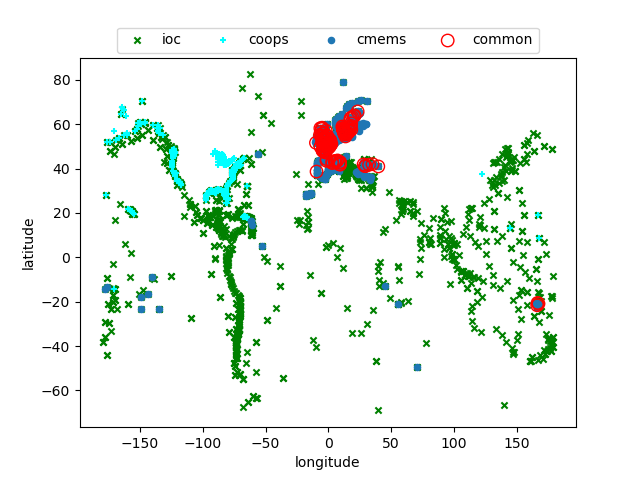

In [49]:
ioc_stations.plot.scatter(x = 'longitude', y = 'latitude', color='green', marker='x', label='ioc')
a = plt.gca()
coops.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='cyan', marker='+', label='coops')
cmems.plot.scatter(ax=a, x = 'longitude', y = 'latitude', marker='o', label='cmems')
plt.scatter(x=db2.longitude, y=db2.latitude, s=80, facecolors='none', edgecolors='r', label='common')
plt.legend(loc='upper center',bbox_to_anchor=(.5, 1.1), ncol=4)

### merge cmems

In [50]:
catalog = pd.concat([catalog, cmems], ignore_index=True)

catalog.reset_index(inplace=True,drop=True)
catalog

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,lastupdate,lastvalue,connect,countryname,nws_id,state,removed,PLATFORM_CODE,INSTITUTION,INSTITUTION_EDMO_CODE
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,2023-09-08 08:47:09.717,2.395728,SWJP40,Japan,<NA>,<NA>,<NA>,NaN,NaN,NaN
1,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,2023-09-08 08:48:05.000,3.400000,SF,UK,<NA>,<NA>,<NA>,NaN,NaN,NaN
2,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,2023-09-08 08:47:09.840,2.749296,SWJP40,Japan,<NA>,<NA>,<NA>,NaN,NaN,NaN
3,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,2023-09-08 08:45:04.497,6.173000,SZXX01,El Salvador,<NA>,<NA>,<NA>,NaN,NaN,NaN
4,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,2017-07-07 01:06:04.923,8.257000,SEPA40,Mexico,<NA>,<NA>,<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,NaN,Iles Du Salut,NaN,NaN,NaN,NaN,NaN,5.250000,-52.620000,NaN,...,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,IlesDuSalutTG,SHOM Service Hydrographique et Oceanographiqu...,540
2501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.726300,33.340200,NaN,...,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,IDSL-ZygiMarina,Joint Research Centre(JRC);Cyprus Oceanography...,2688 711
2502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.942500,22.933600,NaN,...,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,IDSL-Corinth,Joint Research Centre(JRC);National Observator...,2688 1202
2503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.987600,3.828150,NaN,...,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,IDSL-Ciutadella,Joint Research Centre(JRC);Instituto Geogr\u00...,2688


### test IOC and CMEMS data

In [51]:
cc = catalog.loc[catalog.Station_Name.isin(db2_.Station_Name)]

In [52]:
test = cc.loc[cc.Station_Name=="Bangor"]
test = test.rename(columns={'longitude':'lon','latitude':'lat','Country':'country','Station_Name':'location'})

#### IOC

In [53]:
url = "http://www.ioc-sealevelmonitoring.org/bgraph.php?code={}&output=tab&period=30&endtime={}".format('bang','2023-7-30') # use IOC code value
url

'http://www.ioc-sealevelmonitoring.org/bgraph.php?code=bang&output=tab&period=30&endtime=2023-7-30'

In [54]:
data = ioc.get_ioc_data(
    ioc_metadata=test,
    endtime="2023-08-30",
    period=30,
)
data = data.to_dataframe().reset_index(level= 'ioc_code',drop=True)
data = data.rename(columns={'bub':'slev','lon':'longitude','lat':'latitude','country':'Country','location':'Station_Name'})
data = data['slev']
data

100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


time
2023-07-31 00:00:00    2.532
2023-07-31 00:15:00    2.393
2023-07-31 00:30:00    2.248
2023-07-31 00:45:00    2.110
2023-07-31 01:00:00    1.963
                       ...  
2023-08-27 06:15:00    2.890
2023-08-27 06:30:00    2.932
2023-08-27 06:45:00    2.945
2023-08-27 07:00:00    2.964
2023-08-27 07:15:00    2.962
Name: slev, Length: 2599, dtype: float64

#### CMEMS

In [55]:
from erddapy import ERDDAP

e = ERDDAP(
  server="https://nrt.cmems-du.eu/erddap",
  protocol="tabledap",
)


In [56]:
e.dataset_id = 'copernicus_GLO_insitu_nrt_TG'

In [57]:
e.constraints = {
    "time>=": "2023-07-30 T00:00:00Z",
    "time<=": "2023-08-30 T00:00:00Z",
    "PLATFORM_CODE=": "Bangor",
}


In [58]:
e.variables = [
    "time",
    "SLEV"
]


In [59]:
df = e.to_pandas()#low_memory=False)

df['time (UTC)'] = pd.DatetimeIndex(df['time (UTC)'])
df = df.set_index('time (UTC)')

df.index = df.index.tz_convert(None)
df.columns = ['slev']
df['slev'] = df['slev'].apply(pd.to_numeric)
df

,slev
time (UTC),
2023-08-08 00:00:00,1.969
2023-08-08 00:15:00,2.131
2023-08-08 00:30:00,2.295
2023-08-08 00:45:00,2.462
2023-08-08 01:00:00,2.617
...,...
2023-08-29 23:00:00,3.255
2023-08-29 23:15:00,3.147
2023-08-29 23:30:00,3.013


In [60]:
(data['2023-07-01 0:0:0':'2022-07-29 0:0:0'] - df['2023-07-01 0:0:0':'2023-07-30 0:0:0']).max()

slev   NaN
dtype: float64

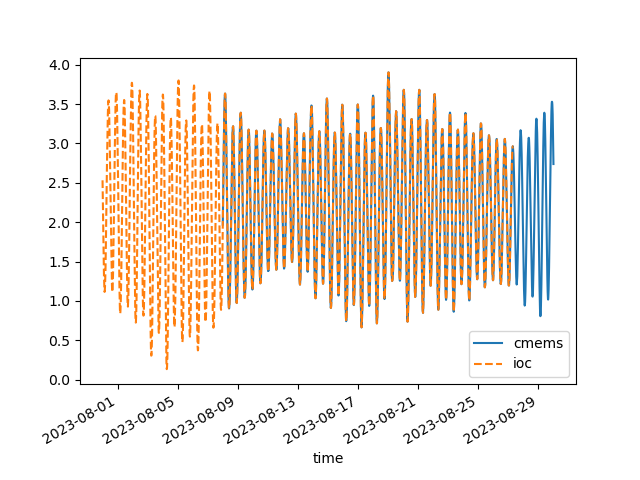

In [61]:
df.plot()
p=plt.gca()
data.plot(ax=p, linestyle='--')
plt.legend(['cmems','ioc'])

#### check duplicates with EMODNET

In [62]:
de = emodnet.Station_Name.isin(catalog.Station_Name)
de.sum()

0

### merge emodnet

In [63]:
catalog = pd.concat([catalog,emodnet], ignore_index=True)

catalog

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,area,author,source,contributor_name,contributor_url,data_assembly_center,institution_edmo_code,institution_references,institution,wmo_platform_code
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,NaN,SolenzaraTG,NaN,NaN,NaN,NaN,NaN,41.856860,9.403830,NaN,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540.0,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
2578,NaN,ThioTG,NaN,NaN,NaN,NaN,NaN,-21.613810,166.241530,NaN,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540.0,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
2579,NaN,ToulonTG,NaN,NaN,NaN,NaN,NaN,43.122800,5.914600,NaN,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540.0,NaN,SHOM Service Hydrographique et Oceanographique...,NaN
2580,NaN,TubuaiTG,NaN,NaN,NaN,NaN,NaN,-23.341770,-149.475540,NaN,...,Global Ocean,NaN,land/onshore structure,NaN,NaN,Ifremer,540.0,NaN,SHOM Service Hydrographique et Oceanographique...,NaN


## Merge GESLA3

In [64]:
m2 = pd.merge(catalog,gesla3, on=['Station_Name']).Station_Name
m2

0      Abashiri
1      Abashiri
2      Aberdeen
3      Aberdeen
4      Aberdeen
         ...   
935    Rosslare
936    Rosslare
937     Wexford
938        Wick
939        Wick
Name: Station_Name, Length: 940, dtype: object

In [65]:
i2 = catalog.loc[catalog.Station_Name.isin(m2)]
i2 = i2.drop_duplicates(['Station_Name']).reset_index(drop=True)
i2 = i2.sort_values('Station_Name').reset_index(drop=True)
i2

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,area,author,source,contributor_name,contributor_url,data_assembly_center,institution_edmo_code,institution_references,institution,wmo_platform_code
0,NaN,Aarhus,NaN,NaN,NaN,NaN,NaN,56.150000,10.216700,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aden,Aden,YEM,SL,3686B76A,SXXX33,15.0,12.788300,44.974200,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,work,Workington,GRB,SF,None,None,15.0,54.650000,-3.570000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,yaku,Yakutat_AK,USA,SW,336B0522,SXXX03,6.0,59.548000,-139.735000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,ysta,Ystad2,SVE,SW,None,None,60.0,55.422778,13.825556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,zanz,Zanzibar,TAN,SL,1605D3E0,SXXX33,15.0,-6.150000,39.183300,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
g2 = gesla3.loc[gesla3.Station_Name.isin(m2)]
g2 = g2.sort_values('Station_Name').reset_index(drop=True)
g2

,filename,Station_Name,site_code,country,contributor_abbreviated,contributor_full,contributor_website,contributor_contact,orginator,originator_website,...,start_date_time,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality
0,aarhus-aar-dnk-cmems,Aarhus,Aar,DNK,CMEMS,Copernicus Marine Environment Monitoring Service,https://resources.marine.copernicus.eu/?option...,instacco@ifremer.fr,Danish Meteorological Institute (DMI),www.dmi.dk,...,2005-01-01 00:00:00,2020-12-17 07:50:00,16,0,DVR90,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
1,abashiri-ma02-jpn-jodc_jma,Abashiri,MA02,JPN,JODC_JMA,Japan Oceanographic Data Center,https://jdoss1.jodc.go.jp/vpage/tide.html,analysis@jodc.go.jp,Japan Meteorological Agency,https://jdoss1.jodc.go.jp/vpage/tide.html,...,1967-12-31 15:00:00,2019-12-31 14:00:00,53,0,Zero of Tide Height,Float,Unspecified,-99.9999,Coastal,No obvious issues
2,abashiri-347a-jpn-uhslc,Abashiri,347A,JPN,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,Japan Oceanographic Data Center Japan,Unspecified,...,1968-01-01 00:00:00,2018-12-31 14:00:00,51,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
3,aberdeen-abe-gbr-cmems,Aberdeen,Abe,GBR,CMEMS,Copernicus Marine Environment Monitoring Service,https://resources.marine.copernicus.eu/?option...,instacco@ifremer.fr,National Oceanography Centre (United_Kingdom),http://noc.ac.uk/ http://www.puertos.es,...,1990-01-01 02:00:00,2021-01-31 23:00:00,32,0,Admiralty Chart Datum,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
4,aberdeen-abe-gbr-bodc,Aberdeen,ABE,GBR,BODC,British Oceanographic Data Centre,https://www.bodc.ac.uk/data/hosted_data_system...,enquiries@bodc.ac.uk,British Oceanographic Data Centre,https://www.bodc.ac.uk/data/hosted_data_system...,...,1930-01-01 00:00:00,2021-07-31 23:45:00,73,0,Admiralty Chart Datum (ACD),bubbler,0.001 (m),-99.9999,Coastal,No obvious issues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,workington-wor-gbr-bodc,Workington,WOR,GBR,BODC,British Oceanographic Data Centre,https://www.bodc.ac.uk/data/hosted_data_system...,enquiries@bodc.ac.uk,British Oceanographic Data Centre,https://www.bodc.ac.uk/data/hosted_data_system...,...,1992-01-01 00:00:00,2021-07-31 23:45:00,30,0,Admiralty Chart Datum (ACD),bubbler,0.001 (m),-99.9999,Coastal,No obvious issues
707,yakutat_ak-570a-usa-uhslc,Yakutat_AK,570A,USA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,National Ocean Service (NOS) National Oceani...,Unspecified,...,1961-01-01 09:00:00,2018-12-31 23:00:00,58,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
708,ystad2-yst-swe-cmems,Ystad2,Yst,SWE,CMEMS,Copernicus Marine Environment Monitoring Service,https://resources.marine.copernicus.eu/?option...,instacco@ifremer.fr,Swedish Meteorological and Hydrological Instit...,www.smhi.se,...,2019-07-01 00:00:00,2020-12-17 07:00:00,2,0,BSCD2000,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
709,zanzibar-151a-tza-uhslc,Zanzibar,151A,TZA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,University of Hawaii Sea Level Center (UHSLC)...,Unspecified,...,1984-03-01 10:00:00,2018-12-31 23:00:00,35,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues


In [67]:
print(np.abs(i2.longitude - g2.longitude).max())
print(np.abs(i2.latitude - g2.latitude).max())

313.04527645999997
114.725558


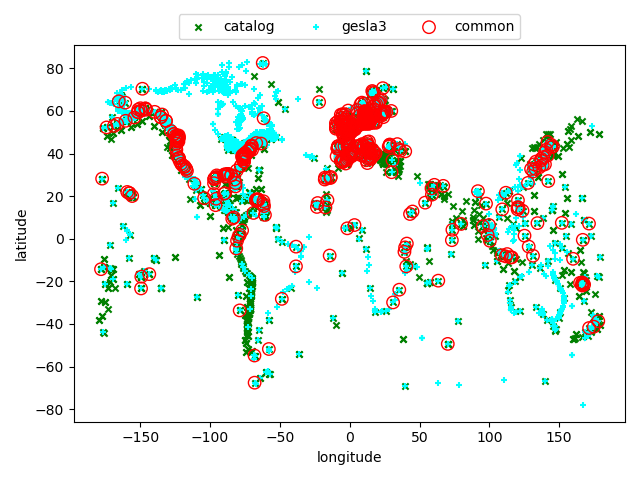

In [68]:
catalog.plot.scatter(x = 'longitude', y = 'latitude', color='green', marker='x', label='catalog')
a = plt.gca()
gesla3.plot.scatter(ax=a, x = 'longitude', y = 'latitude', color='cyan', marker='+', label='gesla3')

plt.scatter(x=i2.longitude, y=i2.latitude, s=80, facecolors='none', edgecolors='r', label='common')
plt.legend(loc='upper center',bbox_to_anchor=(.5, 1.1), ncol=10)
plt.tight_layout()

In [69]:
unique = gesla3[~gesla3.Station_Name.isin(m2)]
unique

,filename,Station_Name,site_code,country,contributor_abbreviated,contributor_full,contributor_website,contributor_contact,orginator,originator_website,...,start_date_time,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality
0,aasiaat-aas-grl-gloss,Aasiaat,AAS,GRL,GLOSS,Global Sea Level Observing System,https://www.gloss-sealevel.org,I.D.Haigh@soton.ac.uk,Global Sea Level Observing System,https://www.gloss-sealevel.org,...,1997-06-26 15:53:00,1999-06-28 11:18:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
1,maniitsoq-man-grl-gloss,Maniitsoq,MAN,GRL,GLOSS,Global Sea Level Observing System,https://www.gloss-sealevel.org,I.D.Haigh@soton.ac.uk,Global Sea Level Observing System,https://www.gloss-sealevel.org,...,1997-06-30 21:02:00,1999-06-20 23:53:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
4,san_francisco_ca-551a-usa-uhslc,San_Francisco_CA,551A,USA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,National Ocean Service (NOS) National Oceani...,Unspecified,...,1897-08-01 08:00:00,2018-12-31 23:00:00,122,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
8,honolulu_hawaii-057b-usa-uhslc,Honolulu_Hawaii,057B,USA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,National Ocean Service (NOS) National Oceani...,Unspecified,...,1905-01-01 10:00:00,2018-12-31 23:00:00,114,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
9,galveston_pier_21-775a-usa-uhslc,Galveston_Pier_21,775A,USA,UHSLC,University of Hawaii Sea Level Center,https://uhslc.soest.hawaii.edu,philiprt@hawaii.edu,National Ocean Service (NOS) National Oceani...,Unspecified,...,1904-01-01 06:00:00,2018-12-31 23:00:00,114,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,puerto_chiapas-318-mex-unam,Puerto_Chiapas,318,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,1986-01-01 00:00:00,1988-12-31 23:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
5113,sanchez_magallanes-417-mex-unam,Sanchez_Magallanes,417,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2016-01-01 00:00:00,2018-12-31 23:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
5114,sian_ka_an-418-mex-unam,Sian_Ka_An,418,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2016-01-01 00:00:00,2018-12-31 23:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
5116,zihuatanejo-509-mex-unam,Zihuatanejo,509,MEX,UNAM,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,mareografico@geofisica.unam.mx,Service Mareographic National Institute of Geo...,http://www.mareografico.unam.mx/portal/,...,2011-01-01 00:00:00,2013-12-30 11:00:00,3,0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues


In [70]:
gesla3 = gesla3.rename(columns={'country':'Country'})

In [71]:
catalog = pd.concat([catalog, gesla3],ignore_index=True)
catalog

,ioc_code,Station_Name,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,start_date_time,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality
0,abas,Abashiri,JAP,SL,ABASHIRI,SWJP40,10.0,44.020000,144.290000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abed,Aberdeen,GRB,SF,None,None,15.0,57.140000,-2.080000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abur,Aburatsu,JAP,SL,ABURATSU,SWJP40,10.0,31.580000,131.410000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,acaj,Acajutla_SV,SVD,SL,300434064008810,SZXX01,5.0,13.573792,-89.838128,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,acap,Acapulco_MX,MEX,SL,3540E15A,SEPA40,5.0,16.833300,-99.916600,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696,NaN,Sian_Ka_An,MEX,NaN,NaN,NaN,NaN,19.312667,-87.446333,NaN,...,2016-01-01 00:00:00,2018-12-31 23:00:00,3.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
7697,NaN,Sisal,MEX,NaN,NaN,NaN,NaN,21.161667,-90.048333,NaN,...,2011-01-01 00:00:00,2013-12-30 11:00:00,3.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
7698,NaN,Zihuatanejo,MEX,NaN,NaN,NaN,NaN,17.636667,-101.558333,NaN,...,2011-01-01 00:00:00,2013-12-30 11:00:00,3.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
7699,NaN,Celestun,MEX,NaN,NaN,NaN,NaN,20.858333,-90.403333,NaN,...,2010-01-01 00:00:00,2011-12-31 23:00:00,2.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues


In [72]:
catalog.duplicated('Station_Name').sum()

1528

# Merge all the data together 

In [73]:
grouped_df = catalog.groupby('Station_Name', as_index=False).agg(lambda x: x.dropna().iloc[0] if x.notna().any() else pd.NA)

In [ ]:
grouped_df

,Station_Name,ioc_code,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,start_date_time,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality
0,A Coru\u00f1a 2 tide gauge,<NA>,<NA>,<NA>,NaN,NaN,<NA>,43.357000,-8.389000,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,A Coru\u00f1a ACOR1 TG tide gauge,<NA>,<NA>,<NA>,NaN,NaN,<NA>,43.364400,-8.398900,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,A Coruña,acor1,ESP,SW,NaN,NaN,5.0,43.364444,-8.398889,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,A121,<NA>,NLD,<NA>,NaN,NaN,<NA>,55.400002,3.810000,NaN,...,2015-06-28 00:00:00,2020-10-06 07:40:00,6.0,0.0,MSL,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
4,A2,<NA>,BEL,<NA>,NaN,NaN,<NA>,51.360600,3.118330,NaN,...,2020-02-28 00:00:00,2021-01-12 08:55:00,2.0,0.0,MSL,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,el jadida,elja1,MAR,SB,MO-ELJ1-00,NaN,1.0,33.255622,-8.499783,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6168,papho,<NA>,CYP,<NA>,<NA>,NaN,<NA>,34.755100,32.408798,NaN,...,2014-11-01 00:00:00,2016-08-26 01:00:00,3.0,0.0,Unknown,Unspecified,Unspecified,-99.9999,Coastal,Possible quality control issues
6169,s_Gravendeel,<NA>,NLD,<NA>,<NA>,NaN,<NA>,51.779151,4.625854,NaN,...,1970-10-30 07:00:00,1983-12-31 22:00:00,14.0,0.0,Normal Amsterdam Level,Unspecified,Unspecified,-99.9999,River,No obvious issues
6170,s_Gravendeel_haven,<NA>,NLD,<NA>,<NA>,NaN,<NA>,51.782206,4.625803,NaN,...,1983-12-31 23:00:00,1992-12-31 22:50:00,10.0,0.0,Normal Amsterdam Level,Unspecified,Unspecified,-99.9999,River,No obvious issues


In [ ]:
grouped_df.duplicated(['latitude','longitude']).sum() #there are duplicates

217

In [ ]:
dmask = grouped_df.duplicated(['latitude','longitude'], keep = False)

In [ ]:
s1 = grouped_df.drop_duplicates(['latitude','longitude'])


In [ ]:
s2 = s1.sort_values(['latitude','longitude'])

In [ ]:
ds = s2[['latitude','longitude']].diff() < [0.02,0.02]

In [ ]:
ds_ = ds.all(axis='columns') # get where you match both lat/lon

In [ ]:
s2[ds_ | ds_.shift(-1)]

,Station_Name,ioc_code,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,Har,...,start_date_time,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality
5459,Syowa_Station_Antarctica,<NA>,ATA,<NA>,NaN,NaN,<NA>,-69.007783,39.570283,<NA>,...,1986-12-31 21:00:00,2019-12-31 20:00:00,33.0,0.0,Zero of Tide Height,Float,Unspecified,-99.9999,Coastal,Possible datum issues
5457,Syowa,syow,ANT,SW,NaN,NaN,60.0,-69.007778,39.570278,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1444,Dumont_dUrville,<NA>,ATA,<NA>,NaN,NaN,<NA>,-66.662000,140.010000,<NA>,...,2008-01-16 07:00:00,2010-08-19 20:00:00,3.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
1443,Dumont_D_Urville,<NA>,FRA,<NA>,NaN,NaN,<NA>,-66.661668,140.010001,<NA>,...,1952-05-01 15:00:00,2000-03-02 05:00:00,8.0,0.0,Zero Hydrographique,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
1442,DumontDUrville_60minute,<NA>,FRA,<NA>,NaN,NaN,<NA>,-66.661667,140.009990,<NA>,...,1952-05-01 15:00:00,2017-11-30 23:00:00,22.0,0.0,chart datum,Unspecified,Unspecified,-99.9999,Coastal,Possible datum issues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,Hyde_Parker_Island,<NA>,CAN,<NA>,NaN,NaN,<NA>,76.480000,-97.220000,<NA>,...,1979-03-02 01:00:00,1979-04-13 17:00:00,1.0,0.0,Chart Datum (CD),Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
776,Cameron_Island_West_Side,<NA>,CAN,<NA>,NaN,NaN,<NA>,76.500000,-104.580000,<NA>,...,1985-03-13 21:00:00,1985-04-25 21:00:00,1.0,0.0,Chart Datum (CD),Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
3776,Ny_Alesund,<NA>,NOR,<NA>,NaN,NaN,<NA>,78.928543,11.938015,<NA>,...,2014-01-01 00:00:00,2020-10-10 15:00:00,7.0,0.0,MSL,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues
3775,Ny Ålesund,nyal,NOR,SW,NaN,NaN,10.0,78.928545,11.938015,0.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
dps = s2[ds_ | ds_.shift(-1)].index.tolist()[::2] #find which indices to drop

In [ ]:
s3 = s2.drop(dps)

In [ ]:
s3 = s3.reset_index(drop=True)

In [ ]:
s3.duplicated('Station_Name').sum()

0

In [ ]:
s3['Location'] = s3.Station_Name
s3 = s3.drop('Station_Name',axis=1)

In [ ]:
s3.insert(0,'id',np.empty(len(s3), dtype=str))

In [ ]:
# define flags
fcoops = ~s3.nws_id.isna()
fioc = ~s3.ioc_code.isna()
femodnet = ~s3.platform_code.isna()
fcmems = ~s3.PLATFORM_CODE.isna()
fgesla = ~s3.filename.isna()

In [ ]:
s3.loc[fcoops,'id'] = s3.agg('COOPS-{0[nws_id]}'.format, axis = 1)
s3.loc[fioc,'id'] = s3.agg('IOC-{0[ioc_code]}'.format, axis = 1)
s3.loc[femodnet,'id'] = s3.agg('EMODNET-{0[platform_code]}'.format, axis = 1)
s3.loc[fcmems,'id'] = s3.agg('CMEMS-{0[PLATFORM_CODE]}'.format, axis = 1)
s3.loc[fgesla,'id'] = s3.agg('GESLA-{0[filename]}'.format, axis = 1)

In [ ]:
s3

,id,Station_Name,ioc_code,Country,type,DCP_ID,WMO,XMtInt,latitude,longitude,...,end_date_time,number_of_years,time_zone_hours,datum_information,instrument,precision,null_value,gauge_type,overall_record_quality,Location
0,GESLA-scott_base-663a-nzl-uhslc,Scott_Base,<NA>,NZL,<NA>,<NA>,<NA>,<NA>,-77.850000,166.767000,...,2017-06-13 12:00:00,14.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Scott_Base
1,IOC-syow,Syowa,syow,ANT,SW,<NA>,<NA>,60.0,-69.007778,39.570278,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Syowa
2,GESLA-syowa_antarctica-127a-ata-uhslc,Syowa_Antarctica,<NA>,ATA,<NA>,<NA>,<NA>,<NA>,-69.000000,39.600000,...,2015-12-31 20:00:00,29.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Syowa_Antarctica
3,GESLA-davis-173a-aus-uhslc,Davis,<NA>,AUS,<NA>,<NA>,<NA>,<NA>,-68.450000,77.967000,...,2010-01-28 08:00:00,18.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Davis
4,GESLA-san_martin-681c-arg-uhslc,San_Martin,<NA>,ARG,<NA>,<NA>,<NA>,<NA>,-68.133000,-67.100000,...,1999-02-09 23:00:00,2.0,0.0,Unspecified,Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,San_Martin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,GESLA-newman_bay-3740-can-meds,Newman_Bay,<NA>,CAN,<NA>,<NA>,<NA>,<NA>,81.950000,-60.080000,...,1975-06-03 12:00:00,1.0,0.0,Chart Datum (CD),Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Newman_Bay
3701,GESLA-lincoln_bay-3782-can-meds,Lincoln_Bay,<NA>,CAN,<NA>,<NA>,<NA>,<NA>,82.120000,-62.030000,...,1975-05-29 08:00:00,2.0,0.0,Chart Datum (CD),Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Lincoln_Bay
3702,GESLA-cape_woods_offshore-66710-can-meds,Cape_Woods_Offshore,<NA>,CAN,<NA>,<NA>,<NA>,<NA>,82.270000,-86.800000,...,1983-05-04 18:00:00,1.0,0.0,Chart Datum (CD),Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Cape_Woods_Offshore
3703,GESLA-alert-3765-can-meds,Alert,aler,CAN,SW,<NA>,<NA>,10.0,82.490000,-62.320000,...,2021-04-13 05:00:00,32.0,0.0,Chart Datum (CD),Unspecified,Unspecified,-99.9999,Coastal,No obvious issues,Alert


In [ ]:
s3.to_csv('//home/tomsail/Documents/scripts/Python/seaset/Notebooks/catalog_new.csv')